# Проект: Определение перспективного тарифа для телеком компании.

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Запрос от бизнеса: проанализировать поведение клиентов и сделать вывод — какой тариф лучше. Сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 


#### Описание тарифов
 - Тариф «Смарт»

Ежемесячная плата: 550 рублей

Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:

минута разговора: 3 рубля, сообщение: 3 рубля, 1 Гб интернет-трафика: 200 рублей

 - Тариф «Ультра»
 
Ежемесячная плата: 1950 рублей

Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:

минута разговора: 1 рубль, сообщение: 1 рубль, 1 Гб интернет-трафика: 150 рублей

<b>Содержание:</b>
1. [Получение данных и изучение общей информации.](##step1)  
2. [Предобработка данных.](##step2)
3. [Анализ данных.](##step3)
4. [Проверка гипотез.](##step4)
5. [Выводы.](##step5)


<a id='#step1'></a>  

<b> 1. Получение данных и изучение общей информации.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import math as mt
from scipy import stats as st
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
from matplotlib import pyplot as plt
from math import factorial
from scipy.stats import norm
from matplotlib.pyplot import figure
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,6)
pd.options.mode.chained_assignment = None

In [2]:
calls = pd.read_csv('/datasets/calls.csv')#, sep="\t")
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

def table_info():
    for table in [users, calls, internet, messages, tariffs]:
        print(table.info())
        print(table.head(2))
        print('______________________________________________________________')

table_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None
   user_id  age churn_date       city first_name  last_name    reg_date tariff
0     1000   52        NaN  Краснодар     Рафаил  Верещагин  2018-05-25  ultra
1     1001   41        NaN     Москва       Иван       Ежов  2018-11-01  smart
______________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1

<b> Вывод</b>

Имеем 5 исходных таблиц с информацией о пользователях, звонках, смс, трафике и тарифах.
Пропущенные значения есть только в таблице с пользователями, в столбце с датой окончания использования тарифа. Заполнено лишь 38 из 500, что означает что отказы не очень частое явление. Темой отдельного исследования могло бы стать изучение причины отказов. 

Также видно, что нужно поменять типы некоторых данных, сделаем это ниже.
Уникальный столбец user_id, есть во всех таблицах (кроме тарифов), будем группировать таблицы именно по нему, когда в этом будет необходимость.

Видим, что в целом данные выгружены корректно, названия столбцов не содержат лишних пробелов, все в одном регистре, а также корректно отображают смысл содержания столбца, а значит доработки не требуют. Также нет отрицательных значений в столбцах, где их и не может быть по смыслу.

<b>2. Предобработка данных.<a id='#step2'></a>

<b> 2. 1. Преобразование типов данных:

 2.1.1. Изменение типов данных

In [3]:
def change_type(table, col_name):
    table[col_name] = pd.to_datetime(table[col_name], format='%Y-%m-%dT%')#H:%M:%S')

change_type(calls, 'call_date')
change_type(internet, 'session_date')
change_type(messages, 'message_date')

In [4]:
calls['duration']= np.ceil(calls['duration']).astype('int')
internet['mb_used'] = np.ceil(internet['mb_used']).astype('int')

<b>2.2.1. Удаление лишних строк.</b>

Удалим из таблицы все строки с длительностью разговора = 0, придерживаясь следующей логики: 

 - во-первых, если в таблице 0, это значит был вызов (входящий или исходящий), но человек не дозвонился, а значит при необходимости перезвонил вновь и, если удачно, то мы увидим этот вызов в списк ненулевых.

 - во-вторых, в исследовании мы хотим проанализировать какой из тарифов более прибылен для провайдера, а поскольку нулевые звонки не были оплачены, то они только исказят статистику.

 - в-третьих, таких звонков около 20%, что много, однако и при их удалении мы все равно имеем достаточную выборку строк для реалистичного анализа.

In [5]:
calls = calls.query('duration  != 0')
print(calls.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162994 entries, 2 to 202606
Data columns (total 4 columns):
id           162994 non-null object
call_date    162994 non-null datetime64[ns]
duration     162994 non-null int64
user_id      162994 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB
None


<b>2.2. Дополнительные расчеты для каждого пользователя. </b>

<b>2.2.1. Рассчитаем следующие величины:</b>
 - количество сделанных звонков и израсходованных минут разговора по месяцам;
 - количество отправленных сообщений по месяцам;
 - объем израсходованного интернет-трафика по месяцам;

In [6]:
#добавим столбцы с месяцем в каждую из нужных таблиц
def add_month(tab, col):
    tab['month'] = pd.DatetimeIndex(tab[col]).month
    
add_month(calls, 'call_date')
add_month(messages, 'message_date')
add_month(internet, 'session_date')

In [7]:
#количество сделанных звонков и израсходованных минут разговора по месяцам
calls_piv = calls.pivot_table(index=['user_id','month'],  values=['duration'], aggfunc=['sum','count']).reset_index()
calls_piv.head()

,user_id,month,sum,count
,,,duration,duration
0,1000,5,159,17
1,1000,6,172,28
2,1000,7,340,41
3,1000,8,408,42
4,1000,9,466,46


In [8]:
#количество отправленных сообщений по месяцам
messages_piv = messages.pivot_table(index=['user_id','month'],  values=['message_date'], aggfunc=['count']).reset_index()
messages_piv.head(2)

,user_id,month,count
,,,message_date
0,1000,5,22
1,1000,6,60


In [9]:
#объем израсходованного интернет-трафика по месяцам
internet_piv = internet.pivot_table(index=['user_id','month'],  values=['mb_used'], aggfunc=['sum']).reset_index()
internet_piv.head(2)

,user_id,month,sum
,,,mb_used
0,1000,5,2256
1,1000,6,23257


In [10]:
#объединим таблицы 
data = (calls_piv.merge(messages_piv, on=['user_id','month'], how='outer')
                  .merge(internet_piv, on=['user_id','month'], how='outer')
                  .fillna(0))

data.columns = ['user_id','month','sum_duration','count_duration','messages_sum','sum_mb_used']
data.dropna(subset=['sum_duration','count_duration','messages_sum','sum_mb_used'], inplace=True)
data.head(3)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


,user_id,month,sum_duration,count_duration,messages_sum,sum_mb_used
0,1000,5,159.0,17.0,22.0,2256.0
1,1000,6,172.0,28.0,60.0,23257.0
2,1000,7,340.0,41.0,75.0,14016.0


<b>2.2.2. Отсортируем необходимые стобцы и изменим типы данных:

In [11]:
data_tar = (data.merge(users, on=['user_id'], how='outer').fillna(0))
data_tar = data_tar.iloc[:,[0,1,2,3,4,5,7,8,11,12]]

#изменим типы данных на int
def change_type(tab, col, new_type):
    tab[col]= tab[col].astype(new_type)

change_type(data_tar, 'month', 'int')
change_type(data_tar, 'sum_duration', 'int')
change_type(data_tar, 'messages_sum', 'int')
change_type(data_tar, 'sum_mb_used', 'int')
change_type(data_tar, 'count_duration', 'int')

data_tar.head(2)

,user_id,month,sum_duration,count_duration,messages_sum,sum_mb_used,churn_date,city,reg_date,tariff
0,1000,5,159,17,22,2256,0,Краснодар,2018-05-25,ultra
1,1000,6,172,28,60,23257,0,Краснодар,2018-05-25,ultra


In [12]:
def histogram(tab, col, title, x, y):
    tab.hist(col, bins = 30, figsize=(10,5), density = 1);
    plt.title(title);
    plt.xlabel(x);
    plt.ylabel(y);

<b>2.2.3. Построим гистограммы для проверки выбросов:

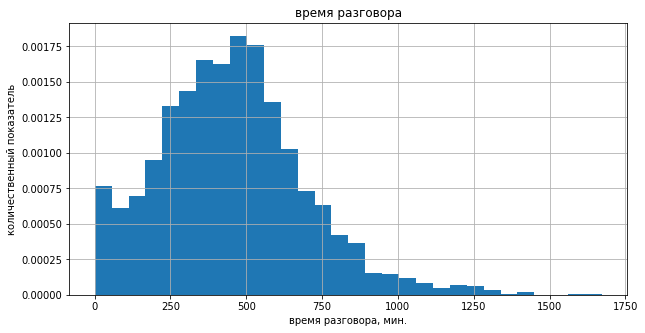

In [13]:
histogram(data_tar,"sum_duration", "время разговора", "время разговора, мин.", "количественный показатель")

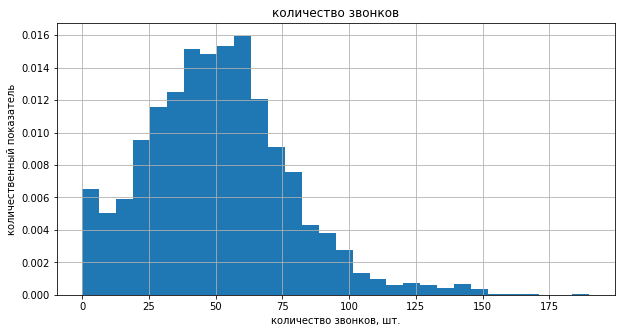

In [14]:
histogram(data_tar,"count_duration", "количество звонков", "количество звонков, шт.", "количественный показатель")

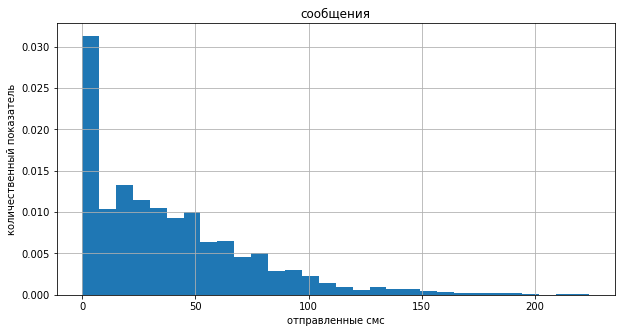

In [15]:
histogram(data_tar,"messages_sum", "сообщения", "отправленные смс", "количественный показатель")

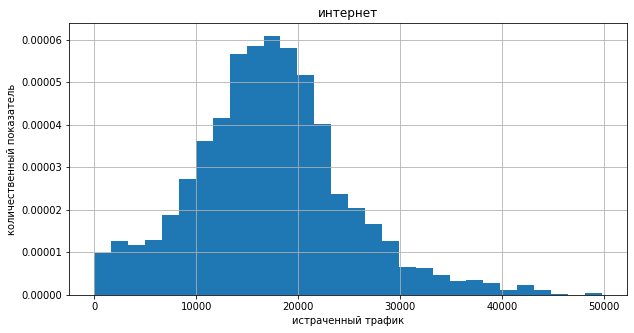

In [16]:
histogram(data_tar,"sum_mb_used", "интернет", "истраченный трафик", "количественный показатель")

<b>2.2.4. Очистка от выбросов.</b>

Из графиков видно, что некоторые пользователи совершают более 150 звонков в месяц и разговаривают более чем по 1000 минут. Будем считать эти значения выбросами, поскольку из графиков видно, что таких пользователей немного.Также отсечем тех, кто отправляет более, чем 150 смс в месяц и тратит более 40000МБ. И дальше рассчитаем расходы клиентов по месяцам.

In [17]:
data_tar = data_tar.query('sum_duration < 1000 & count_duration <110 & messages_sum < 150 & sum_mb_used <40000' )
data_tar.head(2)

,user_id,month,sum_duration,count_duration,messages_sum,sum_mb_used,churn_date,city,reg_date,tariff
0,1000,5,159,17,22,2256,0,Краснодар,2018-05-25,ultra
1,1000,6,172,28,60,23257,0,Краснодар,2018-05-25,ultra


In [18]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<b>2.2.5. Расчитаем помесячную выручку с каждого пользователя, а также разделим таблицы на две по тарифам для упрощения расчетов.

In [19]:
data_tar_s = data_tar.query('tariff == "smart"').reset_index(drop=True)
data_tar_s['income'] = (data_tar_s['sum_duration'].apply(lambda x: (x-500)*3 if x-500>0 else 0)
                       + data_tar_s['messages_sum'].apply(lambda x: (x-50)*3 if x-50>0 else 0)
                       + data_tar_s['sum_mb_used'].apply(lambda x: np.ceil((x-15360)/1024)*200 if x-15360>0 else 0)
                       +550)
data_tar_s.head(3)

,user_id,month,sum_duration,count_duration,messages_sum,sum_mb_used,churn_date,city,reg_date,tariff,income
0,1001,11,430,45,0,18452,0,Москва,2018-11-01,smart,1350.0
1,1001,12,414,47,0,14053,0,Москва,2018-11-01,smart,550.0
2,1002,6,117,14,4,10871,0,Стерлитамак,2018-06-17,smart,550.0


In [20]:
data_tar_u = data_tar.query('tariff == "ultra"').reset_index(drop=True)
data_tar_u['income'] = (data_tar_s['sum_duration'].apply(lambda x: (x-3000) if x-3000>0 else 0)
                       + data_tar_s['messages_sum'].apply(lambda x: (x-1000) if x-1000>0 else 0)
                       + data_tar_s['sum_mb_used'].apply(lambda x: np.ceil((x-30720)/1024)*150 if x-30720>0 else 0)
                       +1950)

data_tar_u.head(3)

,user_id,month,sum_duration,count_duration,messages_sum,sum_mb_used,churn_date,city,reg_date,tariff,income
0,1000,5,159,17,22,2256,0,Краснодар,2018-05-25,ultra,1950.0
1,1000,6,172,28,60,23257,0,Краснодар,2018-05-25,ultra,1950.0
2,1000,7,340,41,75,14016,0,Краснодар,2018-05-25,ultra,1950.0


<b> 3. Анализ данных.<a id='#step3'></a></b>

Проанализируем сколько минут разговора, сообщений и интернет-трафика требуется пользователям каждого тарифа в месяц? 
Посчитайте среднее количество, дисперсию и стандартное отклонение.

In [21]:
spisok=['sum_duration','messages_sum','sum_mb_used','income']

print('ТАРИФ Ultra:')
df1 = data_tar_u[spisok].describe().T[['mean', 'std']].round(2)
df1['variance'] = data_tar_u.var().round(2)
print(df1)
print('-----------------------------------------------\n')

print('ТАРИФ Smart:')
df2 = data_tar_s[spisok].describe().T[['mean', 'std']].round(2)
df2['variance'] = data_tar_u.var().round(2)
print(df2)
print('-----------------------------------------------')

ТАРИФ Ultra:
                  mean      std     variance
sum_duration    470.28   260.71     67971.34
messages_sum     42.65    40.33      1626.43
sum_mb_used   18402.85  9384.22  88063539.12
income         1954.94    60.24      3628.55
-----------------------------------------------

ТАРИФ Smart:
                  mean      std     variance
sum_duration    415.61   186.72     67971.34
messages_sum     33.35    28.23      1626.43
sum_mb_used   16197.66  5862.25  88063539.12
income         1285.45   802.18      3628.55
-----------------------------------------------


Построим гафики для большей наглядности и посмотрим на распределения:

In [22]:
def graf(col):
    ax = data_tar_u.plot(kind='hist', y=col, histtype='step', bins=50, linewidth=1, label='ultra')
    data_tar_s.plot(kind='hist', y=col, histtype='step', bins=50, linewidth=1, label='smart', ax=ax, grid=True, legend=True)

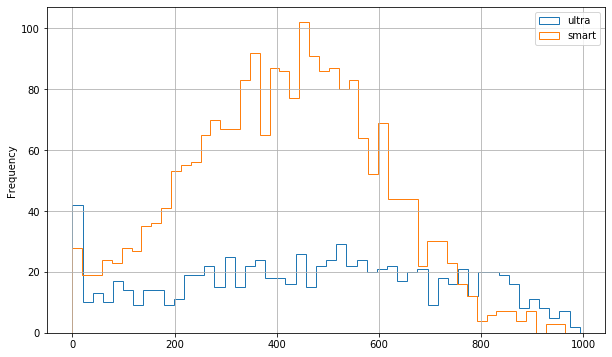

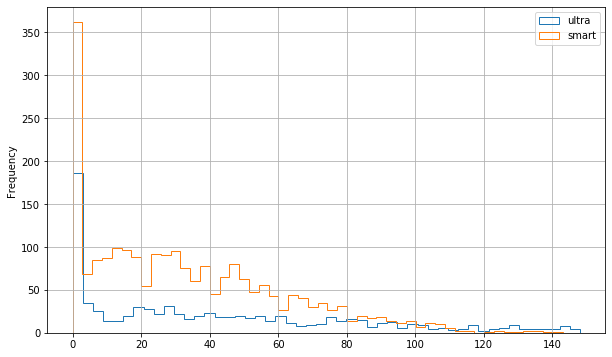

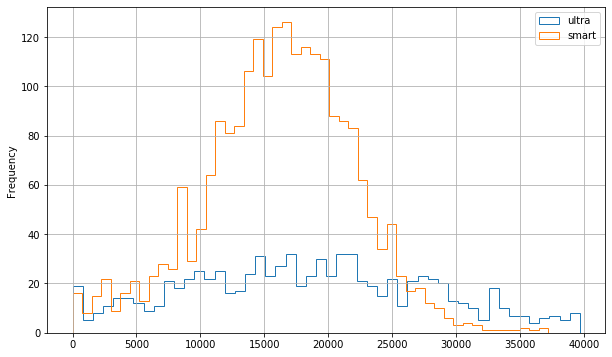

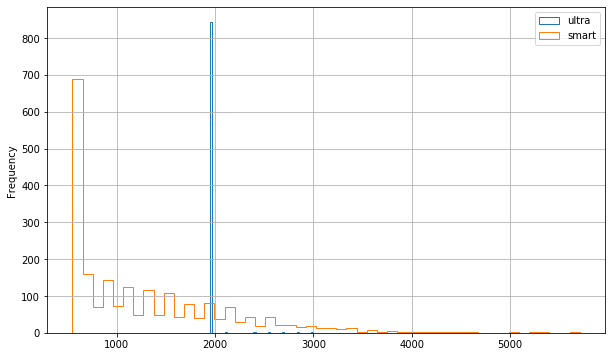

In [23]:
for i in spisok:
    graf(i)

<b>Вывод:</b>

Видно, что клиентам, использущим тариф Smart в среднем хватает включенных в абонентскую плату звонков и смс, а за дополнительный интернет-трафик приходится периодически доплачивать. Возможно, это всязано с тем, что большинство клиентов переключается на звонки и смс через мессенджеры, а значит используют интернет.
Пользователи тарифа Ultra редко доплачивают за дополнительные услуги, им хватает того, что включено в абонентскую плату, при этом остается достаточно приличный неизрасходованный запас.

В целом можно сказать, что люди примерно одинаково тратят в месяц минут, смс и трафика на обоих тарифах, однако для бизнеса выгоднее продавать тариф Ultra, поскольку (даже с учетом всех доплат по Smart) выручка с него значительно выше.

<b>4. Проверка гипотез:<a id='#step4'></a></b>

<b> 4.1. Гипотеза 1:</b>


Нулевая гипотеза будет звучать так:
Средняя выручка пользователей тарифов «Ультра» и «Смарт» равны;

Тогда альтернативная гипотеза будет звучать следующим образом: 
Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;

In [24]:
smart = data_tar_s[['income']]
ultra = data_tar_u[['income']]

# Критический уровень статистической значимости. Если p-value будет меньше него, нужно отвергнуть гипотезу
alpha = 0.05 

# Проверка гипотезы о равенстве средних двух совокупностей
results = st.ttest_ind(ultra, smart)    

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение: [1.30272678e-119]
Отвергаем нулевую гипотезу


<b> 4.1. Гипотеза 2:</b>

Нулевая гипотеза будет звучать так: Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов;

Тогда альтернативная гипотеза будет звучать следующим образом: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

In [25]:
moscow = data_tar_s.query('city == "Москва"')['income']
other = data_tar_s.query('city != "Москва"')['income']

#print(moscow)
#print(other)

# Критический уровень статистической значимости. Если p-value будет меньше него, нужно отвергнуть гипотезу
alpha = 0.05 

# Проверка гипотезы о равенстве средних двух совокупностей
results = st.ttest_ind(other, moscow)    

print('p-значение:', round(results.pvalue,6))
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.198129
Не получилось отвергнуть нулевую гипотезу


Не получилось опровергнуть нулевую гипотезу. Полученное значение p-value говорит о том, что хотя средняя выручка по регионам и Москве не одинакова, с вероятностью в почти 20% такое различие можно получить случайно. В выборку из Москву попало лишь 385 клиентов, в остальных городах 1838. На мой взгляд, выборка по Москве мала, чтобы делать вывод о значимом различии между средней выручкой, поскольку отклонение может быть велико.

<b> 5. Общий вывод: <a id='#step5'></a></b>

Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;
Итоговый вывод:

Клиенты, использующие тариф Смарт тратят несколько меньше минут, смс и трафика в месяц, чем пользователи тарифа Ультра. Но значения примерно равны. Таким образом видно, что клиенты Ультры в среднем сильно переплачивают.
Если смотреть распределение по регионам пользователей, то средняя выручка по другим регионам выше, чем в Москве.

С точки зрения аналитики, очевидно, что Телеком-компания хорошо изучила потребности клиентов, предоставив большинству удобный тариф Смарт с понятной оплатой, а клиентам, желающим чувствовать себя "выше среднего" предоставила Ультру, и есть те, кто готов переплачивать. А возможно клиенты просто не знают об этой переплате. 

Для выбора варианта изменений нужны дополнительные данные и анализ. Ведь не всегда большая выручка говорит о большей доходности, нужно учитывать затраты, поведение и количество клиентов и массу других факторов. Возможны корректровки абонентской платы, лимитов, стоимости экстра услуг, а также различные рекламные компании в разных регионах.

Таким образом, тариф Ultra более прибылен, нежели Smart, если ориентироваться на текущую ситуацию и выручку.